# TS diagrams at boundaries

In [23]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import gsw
import xarray as xr

%matplotlib inline

#### Parameters

In [2]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1600,imax,jmax,jmax) # Northern Canada Basin
bdy_WCB = (imax,imax,391,jmax)  # Western Canada Basin
bdy_LS  = (imin,imin,449,674)   # Labrador Sea
bdy_HB  = (1189,1474,291,291)   # Hudson Bay

In [21]:
# Colors
land_color = '#a9a7a2'
color_sBB  = '#cc0e1d'
color_sGR  = '#ffb7aa'
light_gray = '#b1b1b1'
light_land = '#d0d0cf'
land_edge  = '#929291'

#### Load files

In [4]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

Pb observations:

In [122]:
folder= '/ocean/brogalla/GEOTRACES/data/'

# ------ North Atlantic Ocean, Labrador Sea, Baffin Bay GEOTRACES data -----------
# Observations from: GEOTRACES IDP 2021
df_SW = xr.open_dataset(f'{folder}BB-NA-IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_mX0n8Urd.nc')
SW_ini_lons = df_SW['longitude'].values # degrees east
SW_ini_lats = df_SW['latitude'].values
SW_ini_pressure   = df_SW['var1'].values # pressure from CTD sensor in dbar
SW_ini_depths     = df_SW['var2'].values # depth below sea surface calculated from pressure
SW_ini_temp_C     = df_SW['var3'].values # temperature from CTD sensor in ITS-90 convention
SW_ini_sal_pss78  = df_SW['var4'].values # practical salinity from CTD sensor in PSS-1978 scale
SW_ini_dPb_pmolkg = df_SW['var9'].values # concentration of dissolved Pb in pmol/kg 
SW_ini_dPb_qc     = df_SW['var9_qc'].values # dPb quality control flag (49-good, 50-prob good, 51-prob bad, 52-bad)

SW_Pb_stns = np.array([])
for stn in range(0,len(SW_ini_lons)):
    if sum(~np.isnan(SW_ini_dPb_pmolkg[stn,:])) > 0: # count number of non NaN Pb values at this station
        SW_Pb_stns = np.append(SW_Pb_stns, stn)
        
# SW_Pb_stns contains the indices of stations that have Pb observations
SW_lons       = np.array([SW_ini_lons[int(i)] for i in SW_Pb_stns])
SW_lats       = np.array([SW_ini_lats[int(i)] for i in SW_Pb_stns])
SW_pres       = np.array([SW_ini_pressure[int(i),:] for i in SW_Pb_stns])
SW_dept       = np.array([SW_ini_depths[int(i),:] for i in SW_Pb_stns])
SW_temp       = np.array([SW_ini_temp_C[int(i),:] for i in SW_Pb_stns])
SW_sals       = np.array([SW_ini_sal_pss78[int(i),:] for i in SW_Pb_stns])
SW_dPb_pmolkg = np.array([SW_ini_dPb_pmolkg[int(i),:] for i in SW_Pb_stns])
SW_dPb_qc     = np.array([SW_ini_dPb_qc[int(i),:] for i in SW_Pb_stns])

#-- Unit conversions: ----
SW_lons_tile = np.tile(SW_lons, (268,1)).transpose()
SW_lats_tile = np.tile(SW_lats, (268,1)).transpose()
# practical salinity --> absolute salinity (g/kg)
SW_sal_abs   = gsw.conversions.SA_from_SP(SW_sals, SW_pres, SW_lons_tile, SW_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
SW_density   = gsw.density.rho_t_exact(SW_sal_abs, SW_temp, SW_pres) # kg/m3
SW_dPb_pmolL = SW_dPb_pmolkg * SW_density * 1e-3 # dPb in pmol/kg --> pmol/L

# Apply quality control flags (remove bad and probably bad values)
SW_dPb_pmolL[SW_dPb_qc == 51] = np.nan
SW_dPb_pmolL[SW_dPb_qc == 52] = np.nan

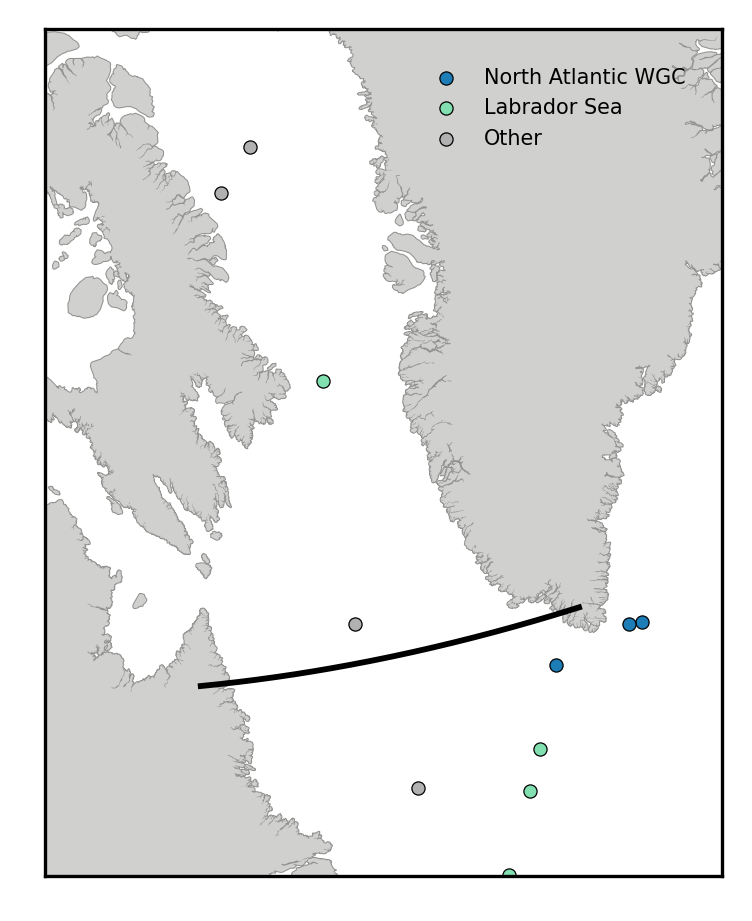

In [198]:
fig, ax1 = plt.subplots(figsize=(4.5, 3.74), dpi=300)

proj1 = Basemap(projection='stere', lat_0 = 65, lon_0 = -55, resolution='i', width=2.0e6, height=2.5e6, ax=ax1)
proj1.drawcoastlines(color=land_edge, linewidth=0.5)
proj1.fillcontinents(color=light_land, lake_color=light_land, zorder=2);

x_obs, y_obs = proj1(SW_lons, SW_lats)
x_mod, y_mod = proj1(mesh_lon, mesh_lat)

proj1.plot(x_mod[bdy_LS[0],bdy_LS[2]:bdy_LS[3]], y_mod[bdy_LS[0],bdy_LS[2]:bdy_LS[3]], '-', c='k', lw=1.4, zorder=4);
proj1.scatter(x_obs[0:3], y_obs[0:3], c='#1c7db7', s=10, edgecolor='k', linewidth=0.3, label='North Atlantic WGC')
proj1.scatter(x_obs[3:8], y_obs[3:8], c='#82dfb0', s=10, edgecolor='k', linewidth=0.3, label='Labrador Sea')
proj1.scatter(x_obs[8:], y_obs[8:], c=light_gray, s=10, edgecolor='k', linewidth=0.3, label='Other')

ax1.legend(fontsize=5, loc=(0.55, 0.85), frameon=False)

In [197]:
ind=1
print(SW_dPb_pmolL[ind][~np.isnan(SW_dPb_pmolL[ind])])
print(SW_dept[ind][~np.isnan(SW_dPb_pmolL[ind])])

[20.34365751 23.43435225 24.05348588 25.49549447 24.67950222 25.6113942
 26.02914287 26.13810258 23.98254865 26.67127406 25.24103869 25.14948442
 30.21370043 27.02941525 28.28016035 21.29571161 18.00365593 19.05089298]
[  18.2   58.1   76.5   98.4  148.2  198.6  247.5  296.5  344.8  445.
  543.   642.8  741.5  841.5  939.1 1285.6 1482.2 1627.5]


In [161]:
# ------ Arctic Ocean data -----------
# Observations from: GEOTRACES IDP 2021
df_NW = xr.open_dataset(f'{folder}AO-IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_H8oFfvOt.nc')
NW_ini_lons = df_NW['longitude'].values # degrees east
NW_ini_lats = df_NW['latitude'].values
NW_ini_pressure   = df_NW['var1'].values # pressure from CTD sensor in dbar
NW_ini_depths     = df_NW['var2'].values # depth below sea surface calculated from pressure
NW_ini_temp_C     = df_NW['var3'].values # temperature from CTD sensor in ITS-90 convention
NW_ini_sal_pss78  = df_NW['var4'].values # practical salinity from CTD sensor in PSS-1978 scale
NW_ini_dPb_pmolkg = df_NW['var9'].values # concentration of dissolved Pb in pmol/kg 
NW_ini_dPb_qc     = df_NW['var9_qc'].values # dPb quality control flag (49-good, 50-prob good, 51-prob bad, 52-bad)

NW_Pb_stns = np.array([])
for stn in range(0,len(NW_ini_lons)):
    if sum(~np.isnan(NW_ini_dPb_pmolkg[stn,:])) > 0: # count number of non NaN Pb values at this station
        NW_Pb_stns = np.append(NW_Pb_stns, stn)
        
# SW_Pb_stns contains the indices of stations that have Pb observations
NW_lons       = np.array([NW_ini_lons[int(i)] for i in NW_Pb_stns])
NW_lats       = np.array([NW_ini_lats[int(i)] for i in NW_Pb_stns])
NW_pres       = np.array([NW_ini_pressure[int(i),:] for i in NW_Pb_stns])
NW_dept       = np.array([NW_ini_depths[int(i),:] for i in NW_Pb_stns])
NW_temp       = np.array([NW_ini_temp_C[int(i),:] for i in NW_Pb_stns])
NW_sals       = np.array([NW_ini_sal_pss78[int(i),:] for i in NW_Pb_stns])
NW_dPb_pmolkg = np.array([NW_ini_dPb_pmolkg[int(i),:] for i in NW_Pb_stns])
NW_dPb_qc     = np.array([NW_ini_dPb_qc[int(i),:] for i in NW_Pb_stns])

#-- Unit conversions: ----
NW_lons_tile = np.tile(NW_lons, (345,1)).transpose()
NW_lats_tile = np.tile(NW_lats, (345,1)).transpose()
# practical salinity --> absolute salinity (g/kg)
NW_sal_abs   = gsw.conversions.SA_from_SP(NW_sals, NW_pres, NW_lons_tile, NW_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
NW_density   = gsw.density.rho_t_exact(NW_sal_abs, NW_temp, NW_pres) # kg/m3
NW_dPb_pmolL = NW_dPb_pmolkg * NW_density * 1e-3 # dPb in pmol/kg --> pmol/L

# Apply quality control flags (remove bad and probably bad values)
NW_dPb_pmolL[NW_dPb_qc == 51] = np.nan
NW_dPb_pmolL[NW_dPb_qc == 52] = np.nan

# Separate into northern Canada Basin and western Canada Basin:
nCB_dPb_pmolL = NW_dPb_pmolL[2:11,:]
nCB_sals      = NW_sals[2:11,:]
nCB_temp      = NW_temp[2:11,:]

wCB_dPb_pmolL = np.vstack([NW_dPb_pmolL[1:4,:], NW_dPb_pmolL[17:21,:]])
wCB_sals      = np.vstack([NW_sals[1:4,:], NW_sals[17:21,:]])
wCB_temp      = np.vstack([NW_temp[1:4,:], NW_temp[17:21,:]])

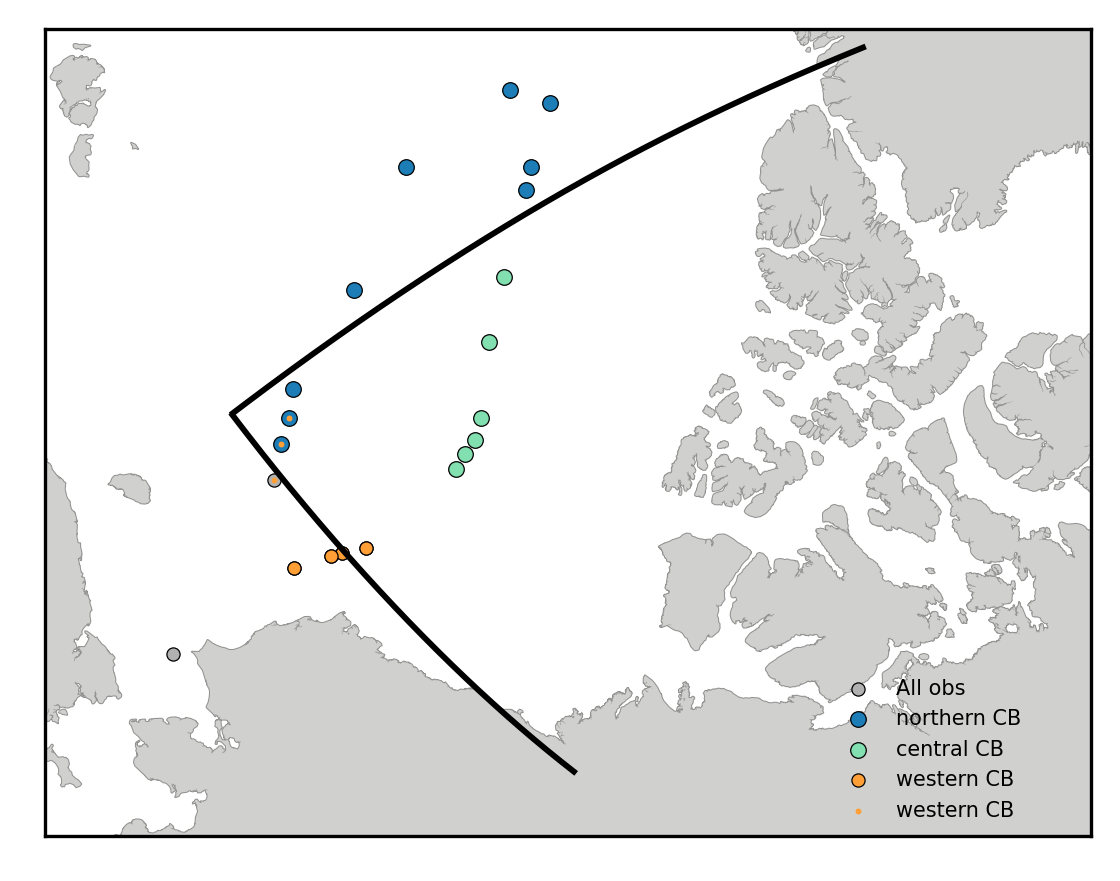

In [152]:
fig, ax1 = plt.subplots(figsize=(4.5, 3.74), dpi=300)

proj1 = Basemap(projection='stere', lat_0 = 78, lon_0 = -135, resolution='i', width=3.5e6, height=2.7e6, ax=ax1)
proj1.drawcoastlines(color=land_edge, linewidth=0.5)
proj1.fillcontinents(color=light_land, lake_color=light_land, zorder=2);

x_obs, y_obs = proj1(NW_lons, NW_lats)
x_mod, y_mod = proj1(mesh_lon, mesh_lat)

proj1.plot(x_mod[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], y_mod[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], '-', c='k', lw=1.4, zorder=4);
proj1.plot(x_mod[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], y_mod[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], '-', c='k', lw=1.4, zorder=4);
proj1.scatter(x_obs[:], y_obs[:], c=light_gray, s=10, edgecolor='k', linewidth=0.3, label='All obs')
proj1.scatter(x_obs[2:11], y_obs[2:11], c='#1c7db7', s=14, edgecolor='k', linewidth=0.3, label='northern CB')
proj1.scatter(x_obs[11:17], y_obs[11:17], c='#82dfb0', s=14, edgecolor='k', linewidth=0.3, label='central CB')
proj1.scatter(x_obs[17:21], y_obs[17:21], c='#ff9f36', s=10, edgecolor='k', linewidth=0.3, label='western CB')
proj1.scatter(x_obs[1:4], y_obs[1:4], c='#ff9f36', s=2, edgecolor='k', linewidth=0.0, label='western CB')
ax1.legend(fontsize=5, loc=(0.75, 0.01), frameon=False)

#### Functions

In [7]:
def plot_density_lines(ax):
    
    density_range     = np.arange(1018,1031,0.5)
    temperature_range = np.linspace(-3,8,20)
    salinity_grid     = np.empty((len(density_range),len(temperature_range)))

    for d,density in enumerate(density_range):
        for t,temperature in enumerate(temperature_range):
            salinity_grid[d,t] = gsw.conversions.SA_from_rho(density, temperature, 0) # sea level pressure in dbar

    temperature_grid, density_grid = np.meshgrid(temperature_range, density_range)
    
    CS = ax.contour(salinity_grid, temperature_grid, density_grid, colors='#717372', levels=20, linestyles='--', linewidths=0.3, zorder=1)    
#     ax.clabel(CS, levels=[1023, 1024, 1025, 1026, 1027, 1028], fontsize=4.5, fmt='%.f', \
#           manual=[(29,-2),(30.5,-2),(31.5,-2),(32.5,-2),(33.5,-2),(35,-2)])
    
    return


In [8]:
def load_climatology(month, bdy=''):        
    # load year 2015 climatology of ANHA12 gridT file:
    df_gridT = xr.open_dataset(f'/data/brogalla/ANHA12/gridT_2015_climatology_{month}.nc')
    
    if bdy=='':
        print('Boundary not specified. Choose one of: LS, wCB, nCB')
    elif bdy=='LS':
        bdy_temp = df_gridT['votemper'].values[0,:,bdy_LS[0]:bdy_LS[0]+rimwidthS,bdy_LS[2]:bdy_LS[3]]
        bdy_sal  = df_gridT['vosaline'].values[0,:,bdy_LS[0]:bdy_LS[0]+rimwidthS,bdy_LS[2]:bdy_LS[3]]
    elif bdy=='wCB':
        bdy_temp = df_gridT['votemper'].values[0,:,bdy_WCB[0]:bdy_WCB[0]+rimwidthN,bdy_WCB[2]:bdy_WCB[3]]
        bdy_sal  = df_gridT['vosaline'].values[0,:,bdy_WCB[0]:bdy_WCB[0]+rimwidthN,bdy_WCB[2]:bdy_WCB[3]]
    elif bdy=='nCB':
        bdy_temp = df_gridT['votemper'].values[0,:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]+rimwidthE]
        bdy_sal  = df_gridT['vosaline'].values[0,:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]+rimwidthE]
    elif bdy=='HB':
        bdy_temp = df_gridT['votemper'].values[0,:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]+rimwidthW]
        bdy_sal  = df_gridT['vosaline'].values[0,:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]+rimwidthW]      
    else:
        print('Boundary name does not exist')
    
#     bdy_dens = gsw.density.sigma0(bdy_sal, bdy_temp)
#     bdy_dens[bdy_dens < 0] = 0
    return bdy_temp, bdy_sal

In [210]:
def create_LS_BC(bdy_temp, bdy_sal, bdy_depth):
    # Pb end-members:
    BBDW_Pb   = 2e-12  # Baffin Bay deep water Pb
    AO_Pb     = 6e-12  # Arctic water Pb
    AW_Pb     = 30e-12 # Atlantic water Pb
    AOAW_Pb   = 25e-12 # Arctic-outflow Atlantic water Pb
    AW_temp   = 5.2    # Atlantic Water temperature
    BBDW_temp = 2.5    # Baffin Bay deep water temperature 
    AW_sal    = 35.2   # Atlantic Water salinity

    # Linear interpolate salinity endpoints:
    end_sal = [33.3, AW_sal]
    end_dPb = [AO_Pb, AOAW_Pb]
    dPb_BC  = np.interp(bdy_sal, end_sal, end_dPb)
    
    # Polar Mixed Layer:
    depth_PML = [0, 100]
    dPb_PML   = [AO_Pb, 10e-12]
    dPb_BC[(bdy_depth < 100) & (bdy_sal > 34)] = np.interp(bdy_depth[(bdy_depth < 100)  & (bdy_sal > 34)], \
                                                           depth_PML, dPb_PML)

    # Baffin Bay deep water:
    end_temp_BBDW = [BBDW_temp, AW_temp]
    end_dPb_BBDW  = [BBDW_Pb, AOAW_Pb]
    dPb_BC[(bdy_sal > 34.8) & (bdy_temp < AW_temp)] = np.interp(bdy_temp[(bdy_sal > 34.8) & (bdy_temp < AW_temp)], \
                                                                  end_temp_BBDW, end_dPb_BBDW)

    # Atlantic Water off Greenland:
    grid = 150 # Grid point of central BB
    boundary_sal = 35.05 # salinity of outer-edge of Atlantic Water core off Greenland
    end_sal_AW   = [boundary_sal, AW_sal]
    end_dPb_AW   = [AOAW_Pb, AW_Pb]
    dPb_BC[:,:,grid:][(bdy_sal[:,:,grid:] > boundary_sal) & (bdy_temp[:,:,grid:] > AW_temp)] =  \
        np.interp(bdy_sal[:,:,grid:][(bdy_sal[:,:,grid:] > boundary_sal) & (bdy_temp[:,:,grid:] > AW_temp)], end_sal_AW, end_dPb_AW)

    return dPb_BC

In [15]:
def create_CB_BC(bdy_temp, bdy_sal):
    # Pb end-members:
    PML_Pb   = 2e-12   # Polar Mixed Layer Pb
    ACW_Pb   = 8e-12  # Alaskan Coastal Water Pb
    wBSW_Pb  = 3e-12   # Winter Bering Sea Water Pb
    AL_Pb    = 5e-12   # Atlantic Water Pb
    CBDW_Pb  = 2e-12   # Canada Basin deep water Pb
    
    PML_sal   = 29      # Polar mixed layer salinity max
    PML_temp  = 0       # Polar mixed layer temperature
    ACW_sal   = 32.5    # ACW salinity
    ACW_temp  = 2       # ACW temperature
    wBSW_temp = 34.8    # Winter Bering Sea Water temperature
    wBSW_sal  = 32.5    # Winter Bering Sea Water salinity
    AL_temp   = 0.1     # Atlantic Water temperature min
    AL_sal    = 34.8    # Atlantic Water salinity min
    CBDW_temp = 0.0    # Canada Basin deep water temperature
    CBDW_sal  = 35.0    # Canada Basin deep water salinity
    
    # Linear interpolate endpoints between PML and ACW:
    end_temp = [PML_temp, ACW_temp]
    end_dPb = [PML_Pb, ACW_Pb]
    dPb_BC  = np.interp(bdy_temp, end_temp, end_dPb)

    # wBSW to AL
    end_sal_AL = [wBSW_sal, AL_sal]
    end_dPb_AL = [wBSW_Pb, AL_Pb]
    dPb_BC[(bdy_sal > wBSW_sal) & (bdy_sal < AL_sal)] = np.interp(bdy_sal[(bdy_sal > wBSW_sal) & (bdy_sal < AL_sal)], \
                                                                  end_sal_AL, end_dPb_AL)
    
    # AL to CBDW
    end_temp_CBDW = [CBDW_temp, AL_temp]
    end_dPb_CBDW  = [CBDW_Pb, AL_Pb]
    dPb_BC[(bdy_sal > AL_sal)] = np.interp(bdy_temp[(bdy_sal > AL_sal)], end_temp_CBDW, end_dPb_CBDW)
    
    
    return dPb_BC

#### Calculations

In [212]:
LS_depth = np.tile(depths, (225,10,1)).transpose()

In [215]:
month=8

LS_T , LS_S  = load_climatology(f'{month:02}', bdy='LS')
wCB_T, wCB_S = load_climatology(f'{month:02}', bdy='wCB')
nCB_T, nCB_S = load_climatology(f'{month:02}', bdy='nCB')
HB_T , HB_S  = load_climatology(f'{month:02}', bdy='HB')

In [216]:
dPb_LS  = create_LS_BC(LS_T , LS_S, LS_depth)
dPb_wCB = create_CB_BC(wCB_T, wCB_S)
dPb_nCB = create_CB_BC(nCB_T, nCB_S)
dPb_HB  = create_CB_BC(HB_T, HB_S)

#### Figures

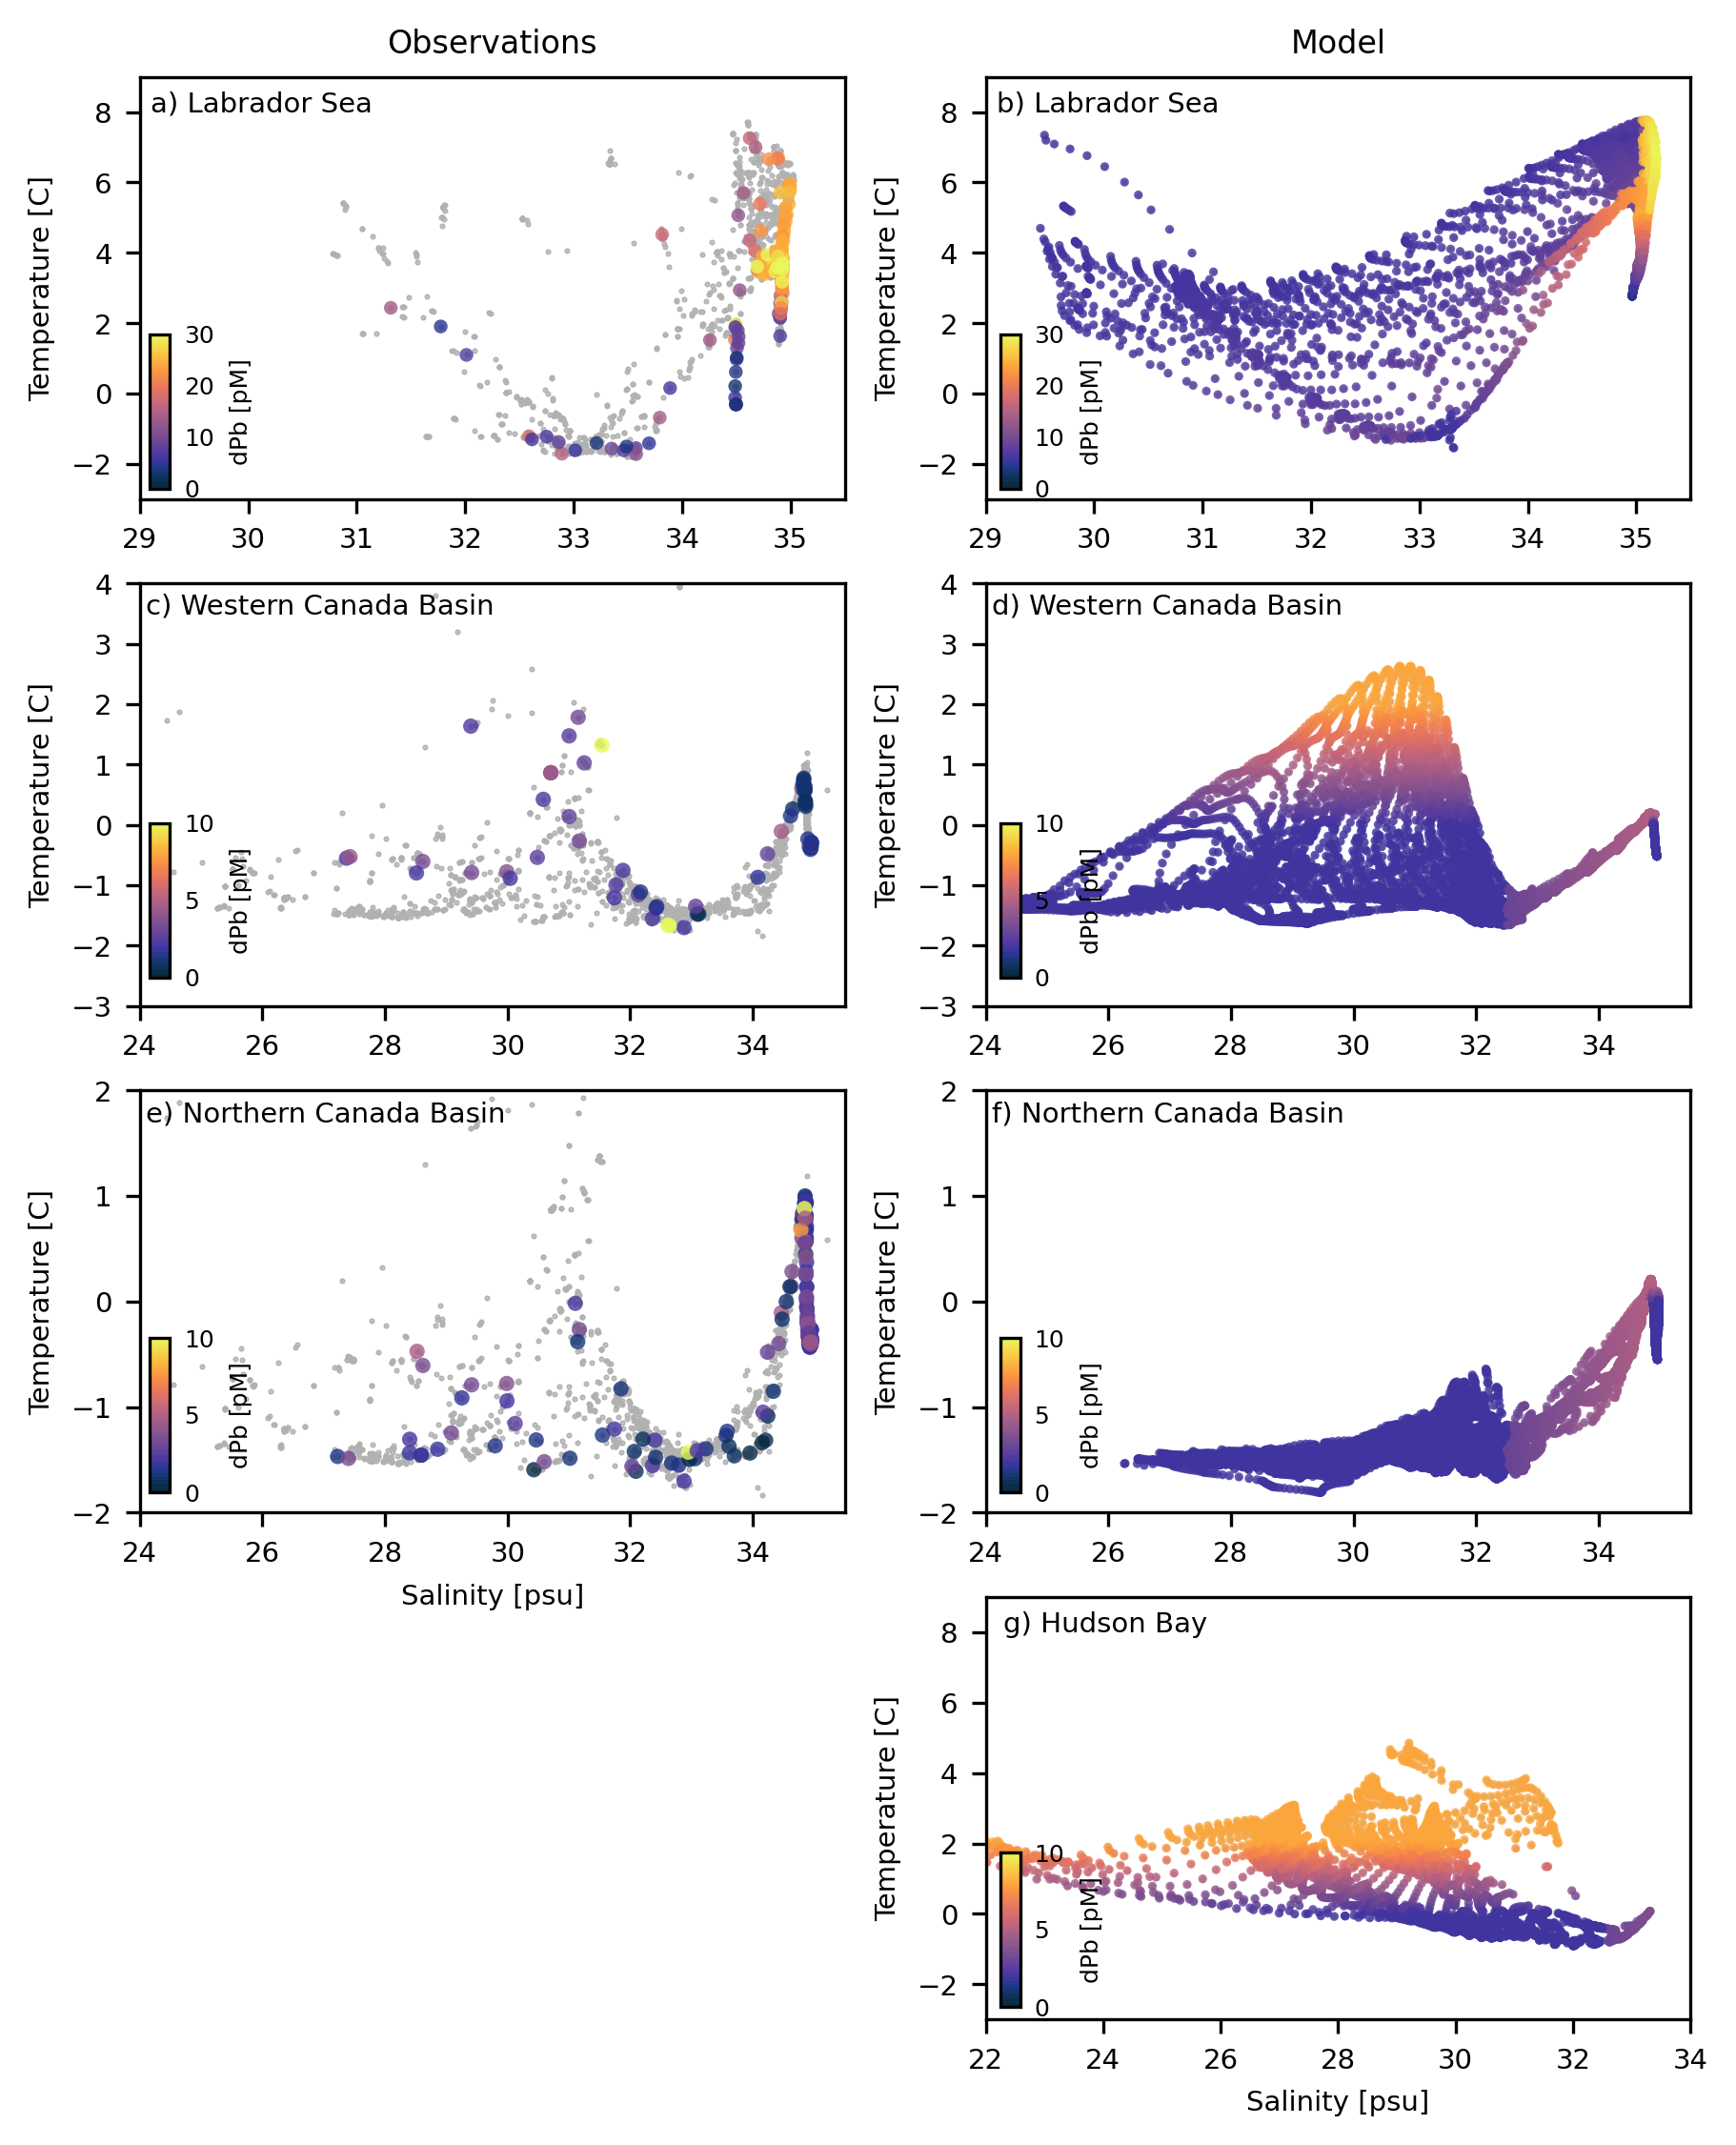

In [217]:
cmap_Pb = cmocean.cm.thermal
vmin_AO = 0; vmax_AO = 10;
vmin_LS = 0; vmax_LS = 30;

fig, ax = plt.subplots(4,2, figsize=(7.0,9), dpi=300)

for n,axis in enumerate(ax.ravel()):
    axis.tick_params(axis='both', labelsize=7)
    axis.set_xlim(24, 35.5)
    axis.set_ylabel('Temperature [C]', fontsize=7)

ax[0,0].set_ylim(-3,9)
ax[0,1].set_ylim(-3,9)
ax[1,0].set_ylim(-3,4)
ax[1,1].set_ylim(-3,4)
ax[2,0].set_ylim(-2,2)
ax[2,1].set_ylim(-2,2)
ax[3,1].set_ylim(-3,9)

ax[0,0].set_xlim(29,35.5)
ax[0,1].set_xlim(29,35.5)
ax[3,1].set_xlim(22,34)
        
ax[2,0].set_xlabel('Salinity [psu]', fontsize=7)
ax[3,1].set_xlabel('Salinity [psu]', fontsize=7)
ax[0,0].set_title('Observations', fontsize=8)
ax[0,1].set_title('Model', fontsize=8)

ax[0,0].text(29.1, 8, 'a) Labrador Sea', fontsize=7);
ax[0,1].text(29.1, 8, 'b) Labrador Sea', fontsize=7);
ax[1,0].text(24.1, 3.5, 'c) Western Canada Basin', fontsize=7);
ax[1,1].text(24.1, 3.5, 'd) Western Canada Basin', fontsize=7);
ax[2,0].text(24.1, 1.7, 'e) Northern Canada Basin', fontsize=7);
ax[2,1].text(24.1, 1.7, 'f) Northern Canada Basin', fontsize=7);
ax[3,0].axis('off')
ax[3,1].text(22.3, 8, 'g) Hudson Bay', fontsize=7);

#----- Observations: ----------------------------------------------------
ax[0,0].scatter(SW_ini_sal_pss78.flatten(), SW_ini_temp_C.flatten(), c=light_gray, s=0.2, zorder=2, alpha=1)
CB1 = ax[0,0].scatter(SW_sals.flatten(), SW_temp.flatten(), c=SW_dPb_pmolL, \
           alpha=0.8, s=12, edgecolor='k', linewidth=0.0, zorder=3, vmin=vmin_LS, vmax=vmax_LS, cmap=cmap_Pb)

ax[1,0].scatter(NW_ini_sal_pss78.flatten(), NW_ini_temp_C.flatten(), c=light_gray, s=0.2, zorder=2, alpha=1)
CB2 = ax[1,0].scatter(wCB_sals.flatten(), wCB_temp.flatten(), c=wCB_dPb_pmolL, \
           alpha=0.8, s=15, edgecolor='k', linewidth=0.0, zorder=3, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)

ax[2,0].scatter(NW_ini_sal_pss78.flatten(), NW_ini_temp_C.flatten(), c=light_gray, s=0.2, zorder=2, alpha=1)
CB3 = ax[2,0].scatter(nCB_sals.flatten(), nCB_temp.flatten(), c=nCB_dPb_pmolL, \
           alpha=0.8, s=15, edgecolor='k', linewidth=0.0, zorder=3, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)

#----- Model: -----------------------------------------------------------
layer  = 0
top    = 0
ax[0,1].scatter(LS_S[:,layer,:] , LS_T[:,layer,:] , c=light_gray, s=0.2, zorder=1, alpha=1)
ax[1,1].scatter(wCB_S[:,layer,:], wCB_T[:,layer,:], c=light_gray, s=0.2, zorder=1, alpha=1)
ax[2,1].scatter(nCB_S[:,:,layer], nCB_T[:,:,layer], c=light_gray, s=0.2, zorder=1, alpha=1)
ax[3,1].scatter(HB_S[:,:,layer] , HB_T[:,:,layer] , c=light_gray, s=0.2, zorder=1, alpha=1)

CB4 = ax[0,1].scatter(LS_S[top:,layer,:] , LS_T[top:,layer,:] , c=dPb_LS[top:,layer,:]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=vmin_LS, vmax=vmax_LS, cmap=cmap_Pb)
CB5 = ax[1,1].scatter(wCB_S[top:,layer,:], wCB_T[top:,layer,:], c=dPb_wCB[top:,layer,:]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)
CB6 = ax[2,1].scatter(nCB_S[top:,:,layer], nCB_T[top:,:,layer], c=dPb_nCB[top:,:,layer]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)
CB7 = ax[3,1].scatter(HB_S[top:,:,layer], HB_T[top:,:,layer], c=dPb_HB[top:,:,layer]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=0, vmax=10, cmap=cmap_Pb)

cbax1 = fig.add_axes([0.13, 0.72, 0.01, 0.06]);
cbax2 = fig.add_axes([0.13, 0.53, 0.01, 0.06]);
cbax3 = fig.add_axes([0.13, 0.33, 0.01, 0.06]);
cbax4 = fig.add_axes([0.555, 0.72, 0.01, 0.06]);
cbax5 = fig.add_axes([0.555, 0.53, 0.01, 0.06]);
cbax6 = fig.add_axes([0.555, 0.33, 0.01, 0.06]);
cbax7 = fig.add_axes([0.555, 0.13, 0.01, 0.06]);
cbaxes = [cbax1, cbax2, cbax3, cbax4, cbax5, cbax6, cbax7]

for n,cb in enumerate([CB1, CB2, CB3, CB4, CB5, CB6, CB7]):
    CBar = plt.colorbar(cb, ax=ax, cax=cbaxes[n]); 
    CBar.set_label('dPb [pM]', fontsize=6)
    CBar.ax.tick_params(axis='y', length=0, labelsize=6)

# cbaxes = fig.add_axes([0.15, 0.15, 0.02, 0.22]);
# CBar   = plt.colorbar(CB1, ax=ax, cax=cbaxes); 
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/TS_observations_LS.jpg', dpi=300, bbox_inches='tight')